# Filmski žanri

Vzorčni projekt pri Programiranju 1.

## Predpriprava

Na začetku naložimo paket in razpredelnice. Če CSV datoteke še ne obstajajo, jih najprej ustvarimo s pomočjo skripte `pripravi_podatke.py`.

In [44]:
import pandas as pd

pd.options.display.max_rows = 30
pd.options.display.max_columns = 16

filmi = pd.read_csv('csv-datoteke/filmi.csv', index_col='id')
osebe = pd.read_csv('csv-datoteke/osebe.csv', index_col='id')
vloge = pd.read_csv('csv-datoteke/vloge.csv')
zanri = pd.read_csv('csv-datoteke/zanri.csv')

In [45]:
%matplotlib inline

## Analiza

### Povprečne ocene žanrov

In [46]:
zanri\
    .join(filmi.ocena, on='film')\
    .groupby('zanr')\
    .mean()\
    .sort_values('ocena', ascending=False)\
    ['ocena']

zanr
Film-Noir    8.153846
Western      7.695652
War          7.600000
History      7.485484
Biography    7.477778
Drama        7.276851
Musical      7.250000
Animation    7.220513
Sport        7.030769
Crime        7.027092
Music        7.024490
Mystery      7.001538
Thriller     6.935463
Adventure    6.864839
Romance      6.855307
Family       6.825610
Fantasy      6.750185
Comedy       6.730492
Sci-Fi       6.699654
Action       6.642533
Horror       6.519008
Name: ocena, dtype: float64

### Popularnost žanrov skozi desetletja

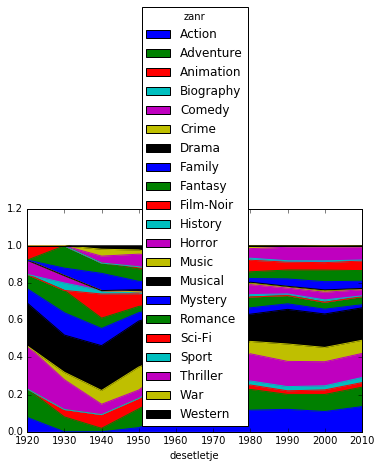

In [47]:
filmi['desetletje'] = 10 * (filmi['leto'] // 10)
zanri\
    .join(filmi, on='film')\
    .groupby(['desetletje', 'zanr'])\
    .size()\
    .unstack()\
    .apply(lambda x: x / x.sum(), axis=1)\
    .plot(kind='area')

## Avtomatično določanje žanrov

In [139]:
def koren_besede(beseda):
    beseda = ''.join(znak for znak in beseda if znak.isalpha())
    if not beseda:
        return '$'
    konec = len(beseda) - 1
    if beseda[konec] in 'ds':
        konec -= 1
    while konec >= 0 and beseda[konec] in 'aeiou':
        konec -= 1
    return beseda[:konec + 1]

def koreni_besed(niz):
    return pd.Series(list({
        koren_besede(beseda) for beseda in niz.replace('-', ' ').lower().split() if beseda
    }))

def koreni_filmov(nizi):
    return nizi[nizi.notnull()].apply(
        koreni_besed
    ).stack().reset_index(level=1, drop=True)

def verjetnosti_po_zanrih(dogodki_po_filmih):
    dogodki_po_filmih.name = 'dogodek'
    dogodki_po_zanrih = zanri.join(pd.DataFrame(dogodki_po_filmih), on='film')
    pogostost_dogodkov = pd.crosstab(dogodki_po_zanrih.dogodek, dogodki_po_zanrih.zanr)
    pogostost_dogodkov += 1
    return pogostost_dogodkov / pogostost_dogodkov.sum()

igralci = vloge[vloge.vloga == 'igralec'].set_index('film').oseba

In [133]:
verjetnost_zanra = zanri.groupby('zanr').size() / len(filmi)
verjetnost_korena_naslova_pri_zanru = verjetnosti_po_zanrih(koreni_filmov(filmi.naslov))
verjetnost_korena_opisa_pri_zanru = verjetnosti_po_zanrih(koreni_filmov(filmi.opis))
verjetnost_igralcev_pri_zanru = verjetnosti_po_zanrih(igralci)

In [140]:
def doloci_zanre(naslov='', opis='', igralci=[]):
    koreni_opisa = koreni_besed(opis)
    koreni_naslova = koreni_besed(naslov)
    verjetnosti_opisov = verjetnost_korena_opisa_pri_zanru[
        verjetnost_korena_opisa_pri_zanru.index.isin(koreni_opisa)
    ]
    verjetnosti_naslovov = verjetnost_korena_naslova_pri_zanru[
        verjetnost_korena_naslova_pri_zanru.index.isin(koreni_naslova)
    ]
    verjetnosti_igralcev = verjetnost_igralcev_pri_zanru[
        verjetnost_igralcev_pri_zanru.index.isin(igralci)
    ]
    faktorji_zanrov = verjetnost_zanra
    if not verjetnosti_opisov.empty:
        faktorji_zanrov *= verjetnosti_opisov.prod()
    if not verjetnosti_naslovov.empty:
        faktorji_zanrov *= verjetnosti_naslovov.prod()
    if not verjetnosti_igralcev.empty:
        faktorji_zanrov *= verjetnosti_naslovov.prod()
    faktorji_zanrov /= max(faktorji_zanrov)
    return faktorji_zanrov.sort_values(ascending=False).head(5)

In [136]:
verjetnost_igralcev_pri_zanru(igralci=[1191])

TypeError: 'DataFrame' object is not callable

In [141]:
doloci_zanre("Sad penguins kill everyone")

zanr
Adventure    1.000000e+00
Comedy       5.048732e-03
Family       7.153591e-07
Thriller     2.881472e-08
Drama        1.303877e-08
dtype: float64